In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/interim')
sys.path.append(ROOT_DIR)  # To find local version of the library


import pandas as pd
import numpy as np
import imageio as iio
import json
from skimage.draw import polygon
import matplotlib.pyplot as plt
import skimage
from typing import Union

In [2]:
# checking for labels of interest
# labels of interest
labels_dict = {
    8: 'sidewalk',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    20: 'traffic sign'
}

labels_dc ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'traffic sign': 20,
            'vegetation': 21}

In [3]:
IMG_DIR = os.path.join(DATA_DIR, 'ZIP.leftImg8bit_trainvaltest.zip/leftImg8bit')
LBL_DIR = os.path.join(DATA_DIR, 'ZIP.gtFine_trainvaltest.zip/gtFine/')

x_train, y_train = IMG_DIR + '/train', LBL_DIR+'/train'
x_test, y_test = IMG_DIR + '/test', LBL_DIR+'/test'
x_val , y_val =IMG_DIR + '/val', LBL_DIR+'/val'

In [4]:
from typing import Union
def parse_json(filename: str, keep:Union[tuple,list,dict]=['sidewalk']):
    polygons = []
    labels = []
    with open(filename) as f:
        data = json.load(f)
        im_h, im_w = data['imgHeight'], data['imgWidth']
        objects = data["objects"]
        for i in objects:
            if i['label'] in keep:
                # if isinstance(keep, dict):
                #     labels.append(keep[i['label']])
                # else:
                #     labels.append(i['label'])
                poly_coords = i['polygon']
                tmp = list(zip(*poly_coords))
            # NOTE: The following line assumes that the point coordinates are given as (x,y). 
            #       Change the order of the indices if needed.
                polygons.append((np.array(tmp[1])-1, np.array(tmp[0])-1))
    # return (im_h, im_w), labels, polygons
    return (im_h, im_w), polygons

# https://stackoverflow.com/questions/72168663/setting-a-list-of-x-y-cooordinates-into-an-array-so-polygons-are-drawn
def drawMask(imgsize: tuple, poly:tuple):
    img = np.zeros(imgsize)
    r = poly[0]
    c = poly[1]
    r_index, c_index = polygon(r, c)
    img[r_index,c_index] = 1
    return img

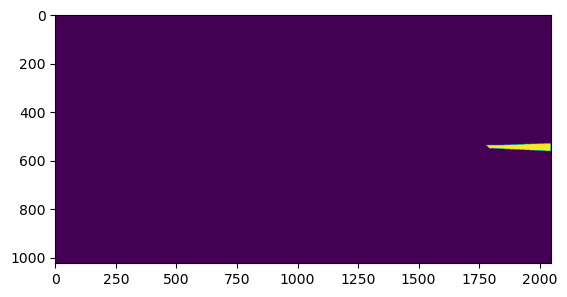

In [11]:
imdim, polygons = parse_json(os.path.join(DATA_DIR,'gtFine/train/aachen/aachen_000000_000019_gtFine_polygons.json'))
m = drawMask(imdim, polygons[0])
plt.imshow(m)

In [7]:
# # get a list of file names from x
# # find y json file 
# # find # of instances no need to generate masks yet
# # img path | json path | class

# def getIds(subset:list):
#     cities = os.listdir(subset)
#     ids = []
#     for city in cities:
#         for p in os.listdir(os.path.join(subset, city)): 
#             id = '_'.join(p.split('_')[:3])
#             ids.append(id)   
#     return ids


# def getInstances(filename:str, labelsToKeep:dict):
#     labels = []
#     keys = labelsToKeep.keys()
#     data = json.load(open(filename))
#     data = data["objects"]
#     for d in data:
#         l = d['label']
#         if l in keys:
#             labels.append(labelsToKeep[l])
#     return labels
    

In [237]:
# train_ids = getIds(x_train)
# test_ids = getIds(x_test)
# val_ids = getIds(x_val)


In [251]:
# def getLabels(ids, x,y,keepLabels={'sidewalk':8}):
#     labels = []
#     for id in ids:
#         city= id.split('_')[0]
#         # im_path = os.path.join(x,city,id+'_leftImg8bit.png')
#         lb_path = os.path.join(y,city, id+'_gtFine_polygons.json')
#         labels.append(getInstances(lb_path,keepLabels))
#     return labels

# def generateCSV(filepath:str, ids, labels):
#     df = pd.DataFrame(data=list(zip(ids, labels)),columns=['ID','LABEL'])
#     df.to_csv(filepath, index=False)

In [249]:
# val_labels = getLabels(val_ids, x_val,y_val)
# generateCSV('/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/interim/val.csv',val_ids,val_labels)

In [13]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

In [14]:
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 2

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 10

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  
class CustomDataset(utils.Dataset):
 
  def add_image(self, source, image_id, path, **kwargs):
        image_info = {image_id:
            {"source": source,
            "path": path,
            }
        }
        image_info[image_id].update(kwargs)
        self.image_info.update(image_info)

  def add_class(self, source, class_id, class_name):
    assert "." not in source, "Source name cannot contain a dot"
    # Does the class exist already?
    if class_id in self.class_info.keys():
       return

    # Add the class
    self.class_info.update({ class_id:
       { "source": source,
        "name": class_name,
        'id': class_id}
    })
        
  def load_dataset(self,dataset_dir,subset):
    self.image_info = {}
    self.class_info = {}
    self.data_directory = dataset_dir

    classes = pd.read_csv(os.path.join(dataset_dir,'classes.csv'))
    IDs, LABELS = classes['CLASS_ID'].tolist(), classes['CLASS_NAME'].tolist()
    classes = dict(zip(IDs, LABELS))

    for i,c in enumerate(classes):
      self.add_class(source='cityscape',
                   class_id = c,
                   class_name=classes[c])
      
    self.class_names = [d['name'] for d in self.class_info.values()]
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'

    data = pd.read_csv(os.path.join(dataset_dir, subset+'.csv'))  

    for i in range(len(data)):
      ID, LABELS = data.loc[i]
      city = ID.split('_')[0]
      img_path = os.path.join(dataset_dir, f'leftImg8bit/{subset}/{city}/{ID}_leftImg8bit.png')
      classes = [int(i) if i!='' else 0 for i in LABELS.strip('[]').split(',')]
      self.add_image(source='cityscape',
                     image_id = ID,
                     path = img_path,
                     classes = classes)
      
  def load_mask(self,id):
    img_info = self.image_info[id]
    path = img_info['path']
    subset = path.split('/')[-3]
    mask_dir = os.path.join(self.data_directory, f'gtFine/{subset}')
    
    city = id.split('_')[0]
    mask_path = os.path.join(mask_dir, city,f'{id}_gtFine_polygons.json')
    # mask_path = os.path.join(mask_dir, city,f'{id}_gtFine_labelIds.png')
    def parse_json(filename: str, keep=self.class_names) :
        polygons = []
        with open(filename) as f:
            data = json.load(f)
            im_h, im_w = data['imgHeight'], data['imgWidth']
            objects = data["objects"]
            for i in objects:
                if i['label'] in keep:
                    print(i['label'])
                    poly_coords = i['polygon']
                    tmp = list(zip(*poly_coords))
                    polygons.append((np.array(tmp[1])-1, np.array(tmp[0])-1))
        # return (im_h, im_w), labels, polygons
        return (im_h, im_w), polygons

    # https://stackoverflow.com/questions/72168663/setting-a-list-of-x-y-cooordinates-into-an-array-so-polygons-are-drawn
    def drawMask(imgsize: tuple, poly:tuple):
        img = np.zeros(imgsize)
        row, col = polygon(poly[0], poly[1])
        img[row,col] = 1
        return img
    
    masks = []
    
    imsize, polygons = parse_json(mask_path)
    for p in polygons:
       mask = drawMask(imsize, p)
       masks.append(mask)
      
    masks = np.stack(masks, axis=-1)
    return masks, img_info['classes']


In [15]:
d = CustomDataset()
d.load_dataset(DATA_DIR,'train')
d.prepare()

TypeError: 'int' object is not subscriptable

In [ ]:
a,b = d.load_mask('aachen_000000_000019')
c = d.load_image('aachen_000000_000019')
visualize.display_top_masks(c,a,b,d.class_info)

NameError: name 'd' is not defined

In [226]:
def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

In [229]:
d.class_info

{8: {'source': 'cityscape', 'name': 'sidewalk', 'id': 8}}

In [231]:
for i in d.class_info:
    print(d.class_info[i]['name'])

sidewalk


In [232]:
[clean_name(d.class_info[c]['name']) for c in d.class_info]

['sidewalk']

In [236]:
d.num_classes = len(d.class_info)
d.class_ids = np.arange(d.num_classes)

In [257]:
info = d.image_info
image_ids = np.arange(len(d.image_info))

In [258]:
{"{}.{}".format(d.image_info[info]['source'], info): id
                                      for info, id in zip(d.image_info, image_ids)}

KeyError: 'id'

# Trial

In [220]:
bboxes = utils.extract_bboxes(a)

In [264]:
config = CustomConfig()
config.display()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
# val_set.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

TypeError: 'int' object is not subscriptable

In [225]:
temp_log = os.path.join(ROOT_DIR,'data/external')
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')


TypeError: Could not build a TypeSpec for <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'tf.math.truediv_1')> with type KerasTensor